# Hybrid model for stock market prediction and analysis using Numerical and Textual data


# Objectives:
- Create a hybrid model for stock price prediction and analysis using historical stock prices coupled with sentimental analysis of news headlinesfor better estimates.
- Stocks analyzed - SENSEX (S&P BSE SENSEX) extracted from stooq (https://stooq.com/db/h/) and pandas datareader (https://pandas-datareader.readthedocs.io/en/latest/) APIs
- Textual data consists of news headline from Times of India. Dataset extrcated from Harvard database (https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DPQMQH)

# Importing libaries:

In [ ]:
%%capture
# Ignore unnecessary warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
%%capture
# Python functionalities
import requests
from io import StringIO
import re
from copy import deepcopy

# Data manipulation and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Fetching stock data from stooq
from pandas_datareader.data import DataReader
from datetime import datetime

In [ ]:
%%capture
# NLTK
# !pip install nltk -> already installed in colab, for other cases run this command also.
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
%%capture
# Textblob
!pip install textblob

from textblob import Word
from textblob import TextBlob

In [ ]:
%%capture
# Model training
!pip install xgboost
!pip install lightgbm
!pip install catboost

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

We have data for only two companies google and apple. so, I used them only for the data analysis

# Numerical data:

## Loading stock data dataset

In [ ]:
# The tech stocks we'll use for this analysis
tech_list = ['AAPL', 'GOOG']
company_name = ["APPLE", "GOOGLE"]

end = datetime(2022, 3, 1)
start = datetime(2021, 3, 1)

# Create an empty list to store DataFrames for each stock
company_list = []

for stock, com_name in zip(tech_list, company_name):
    # Set DataFrame as the Stock Ticker
    stock_data = DataReader(stock, 'stooq', start, end)
    # Add a column for the stock's company name
    stock_data['company_name'] = com_name
    # Append the DataFrame to the list
    company_list.append(stock_data)

# Concatenate the list of DataFrames into a single DataFrame
num_df = pd.concat(company_list, axis=0)
num_df.head()

,Open,High,Low,Close,Volume,company_name
Date,,,,,,
2022-03-01,163.950,165.854,161.239,162.464,8.385206e+07,APPLE
2022-02-28,162.325,164.678,161.697,164.378,9.548666e+07,APPLE
2022-02-25,163.102,164.378,160.151,164.110,9.239031e+07,APPLE
2022-02-24,151.897,162.115,151.318,162.006,1.417861e+08,APPLE
2022-02-23,164.798,165.406,159.035,159.354,9.041645e+07,APPLE


## Analysis of Stock Prices

### Historical view of the closing price of companies

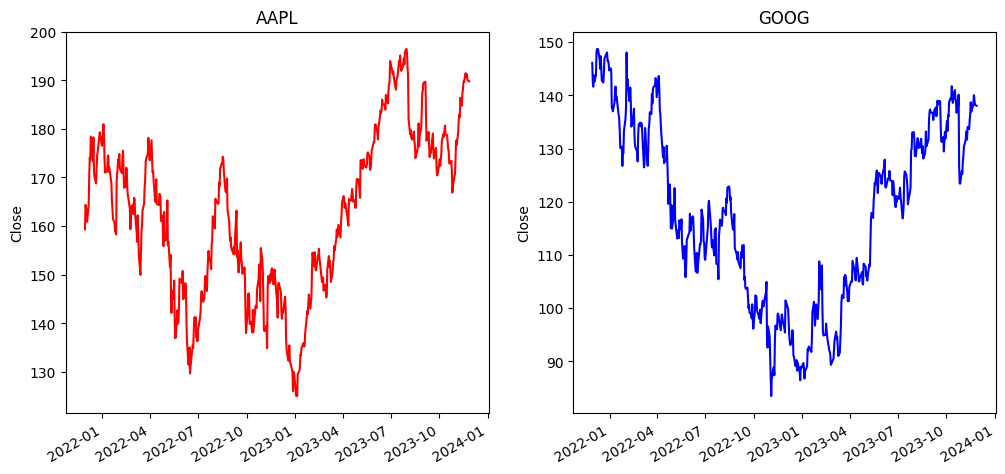

In [ ]:
# Let's see a historical view of the closing price of companies
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
colorlist = ['Red', 'Blue']
for i, stock in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    stock['Close'].plot(color=colorlist[i-1])
    plt.ylabel('Close')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

plt.show()

**Volume**

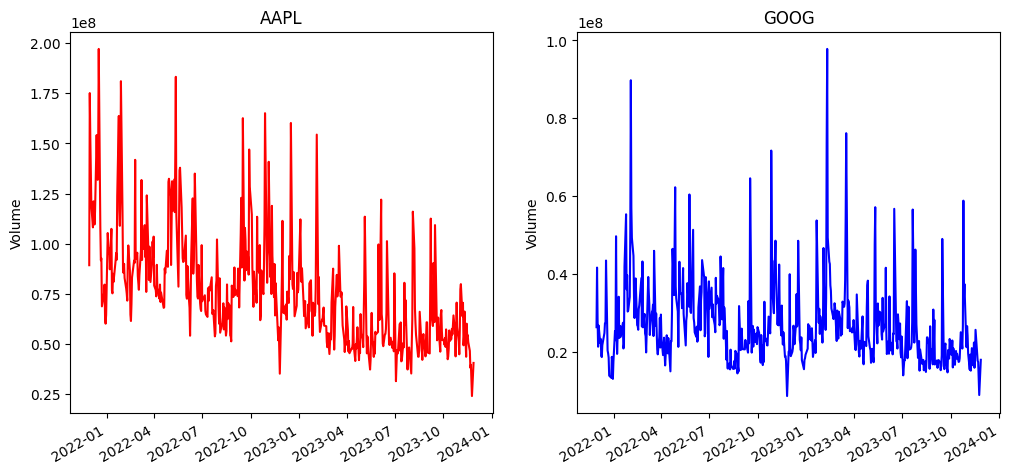

In [ ]:
# Let's see a historical view of the volume of companies
plt.figure(figsize=(12, 8))
plt.subplots_adjust(top=1.25, bottom=1.2)
colorlist = ['Red', 'Blue']
for i, stock in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    stock['Volume'].plot(color=colorlist[i-1])
    plt.ylabel('Volume')
    plt.xlabel(None)
    plt.title(f"{tech_list[i - 1]}")

plt.show()

**The Moving Averages of the various stocks**

In [ ]:
# Set the Moving Average Day
ma_day = [10, 20, 50]

for ma in ma_day:
    for company in company_list:
        column_name = f"MA for {ma} days"
        company[column_name] = company['Close'].rolling(ma).mean()
print("AAPL features ",company_list[0].columns)

AAPL features  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'company_name',
       'MA for 10 days', 'MA for 20 days', 'MA for 50 days'],
      dtype='object')


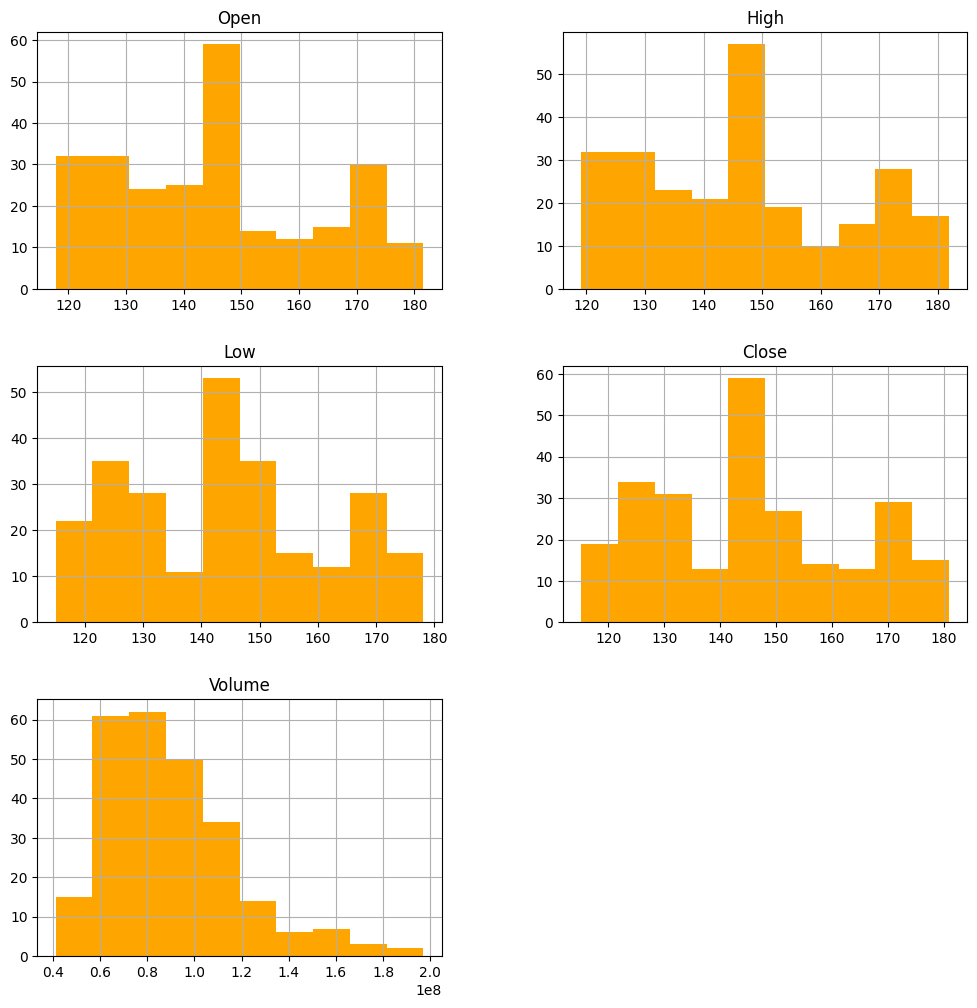

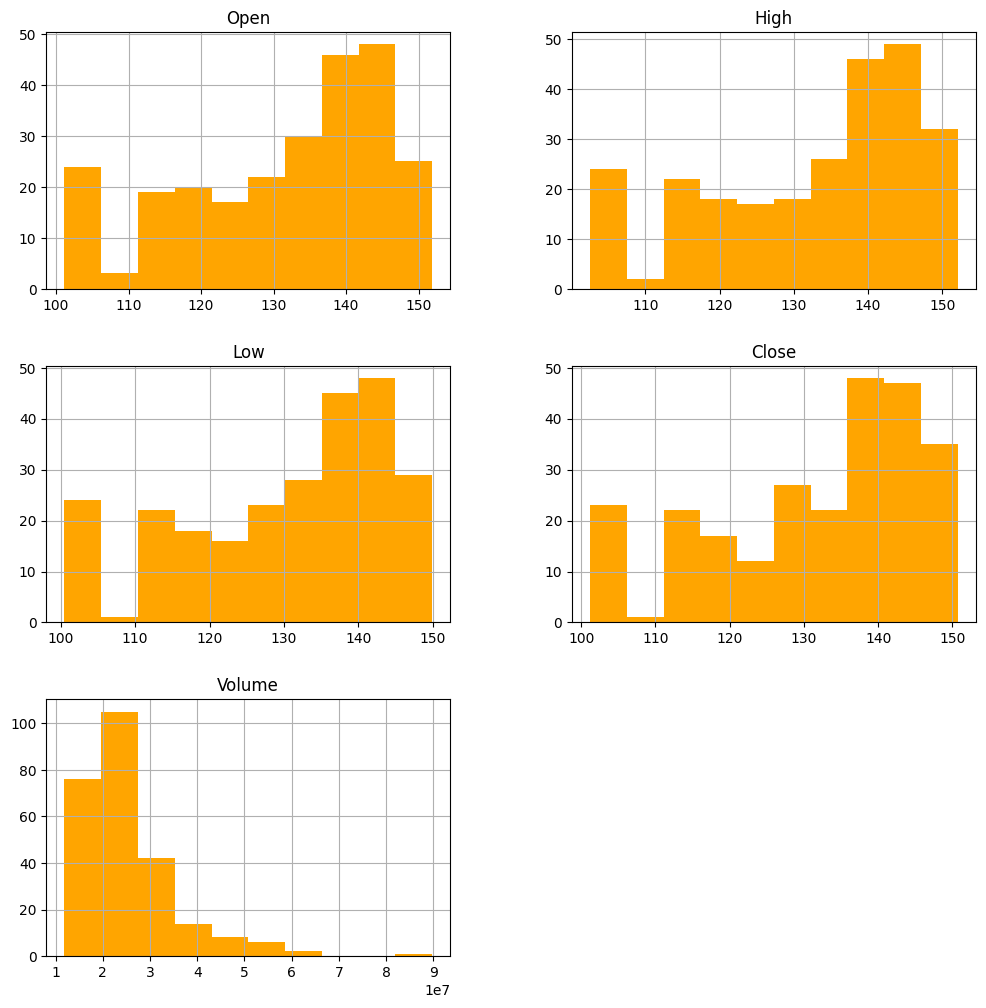

In [ ]:
num_df.groupby("company_name").hist(figsize=(12, 12),color='orange');

**Visualization of companies changes over various MA days and Close**

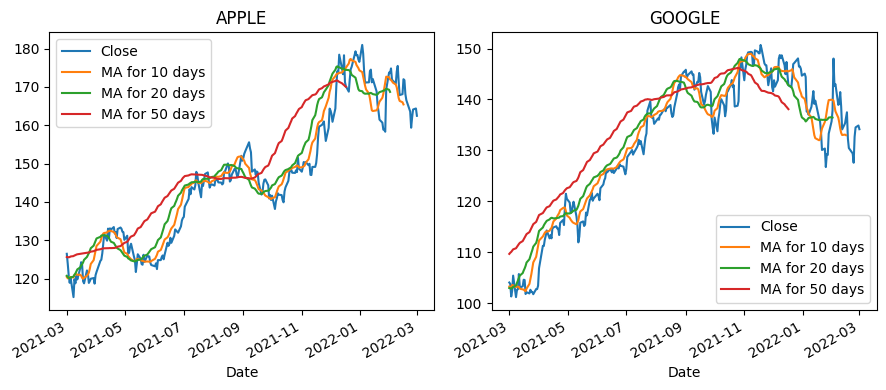

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(9)

company_list[0][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0])
axes[0].set_title('APPLE')

company_list[1][['Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1])
axes[1].set_title('GOOGLE')

fig.tight_layout()

**The daily return of the stock on average.**

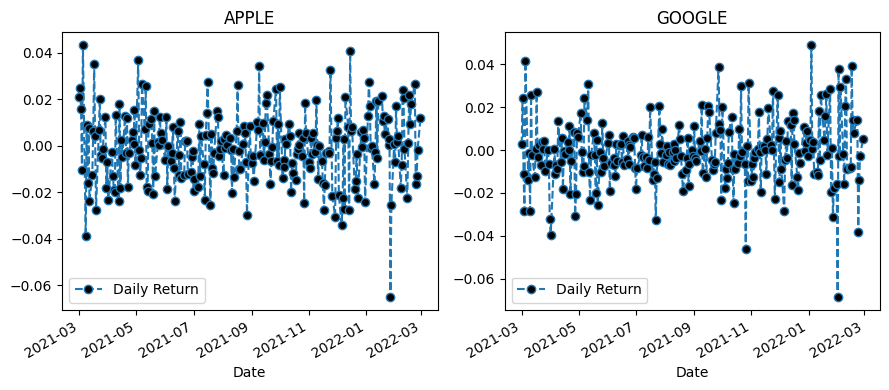

In [ ]:
for company in company_list:
    company['Daily Return'] = company['Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(4)
fig.set_figwidth(9)

company_list[0]['Daily Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o',markerfacecolor='black')
axes[0].set_title('APPLE')

company_list[1]['Daily Return'].plot(ax=axes[1], legend=True, linestyle='--', marker='o',markerfacecolor='black')
axes[1].set_title('GOOGLE')
fig.tight_layout()

APPLE Skewness: -0.064880
APPLE Kurtosis: 0.903596
GOOGLE Skewness: -0.001636
GOOGLE Kurtosis: 2.009742


<Axes: title={'center': 'GOOGLE'}, xlabel='Daily Return', ylabel='Daily Return'>

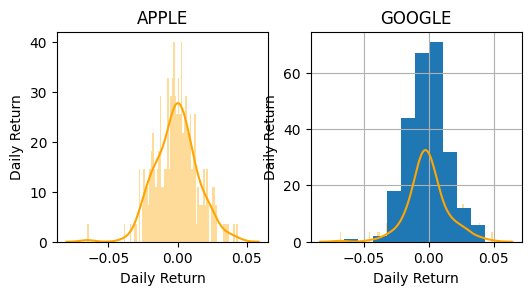

In [ ]:
# Note the use of dropna() here, otherwise the NaN values can't be read by seaborn
plt.figure(figsize=(6, 6))

for i, company in enumerate(company_list, 1):
    plt.subplot(2, 2, i)
    sns.distplot(company['Daily Return'].dropna(), bins=100, color='orange')
    plt.ylabel('Daily Return')
    plt.title(f'{company_name[i - 1]}')
    # Skewness and Kurtosis
    print(f'{company_name[i - 1]}'+" Skewness: %f" % company['Daily Return'].skew())
    print(f'{company_name[i - 1]}'+" Kurtosis: %f" % company['Daily Return'].kurt())
# Could have also done:
company_list[0]['Daily Return'].hist()

### The correlation between different stocks Close prices.

In [ ]:
# Grab all the closing prices for the tech stock list into one DataFrame
closing_df = DataReader(tech_list, 'stooq', start, end)['Close']

# Let's take a quick look
closing_df.head()

Symbols,AAPL,GOOG
Date,,
2022-03-01,162.464,134.168
2022-02-28,164.378,134.891
2022-02-25,164.110,134.520
2022-02-24,162.006,132.674
2022-02-23,159.354,127.585


In [ ]:
tech_rets = closing_df.pct_change()
tech_rets.head()

Symbols,AAPL,GOOG
Date,,
2022-03-01,NaN,NaN
2022-02-28,0.011781,0.005389
2022-02-25,-0.001630,-0.002750
2022-02-24,-0.012821,-0.013723
2022-02-23,-0.016370,-0.038357


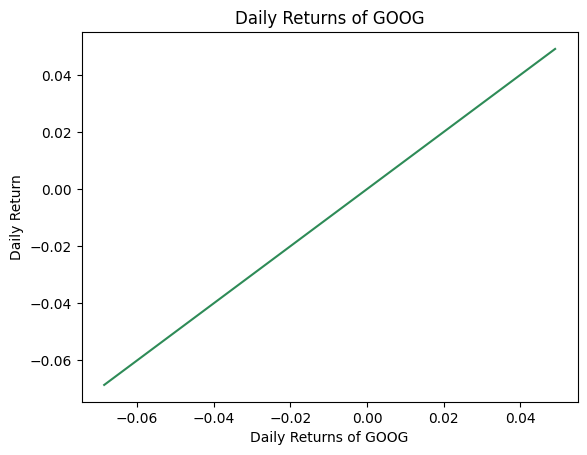

In [ ]:
# Comparing Google to itself should show a perfectly linear relationship
# Plotting the 'GOOG' column against itself
sns.lineplot(x='GOOG', y='GOOG', data=tech_rets, color='seagreen')
plt.title('Daily Returns of GOOG')
plt.xlabel('Daily Returns of GOOG')
plt.ylabel('Daily Return')
plt.show()

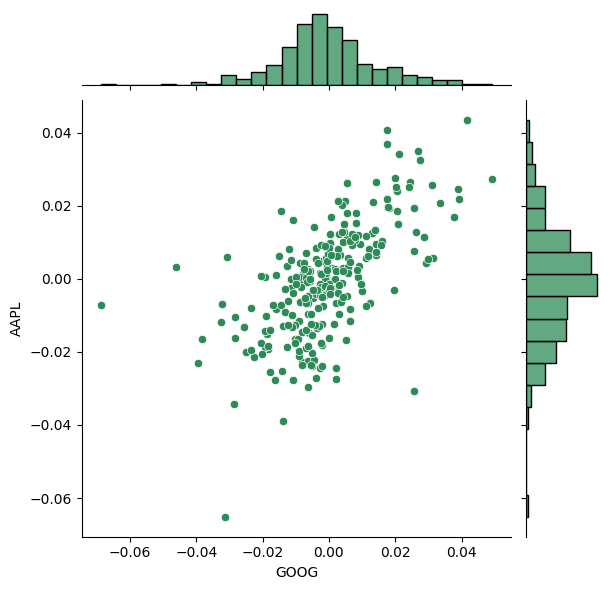

In [ ]:
# Correlation between google and apple
sns.jointplot(x='GOOG', y='AAPL', data=tech_rets, kind='scatter', color='seagreen')
plt.show()

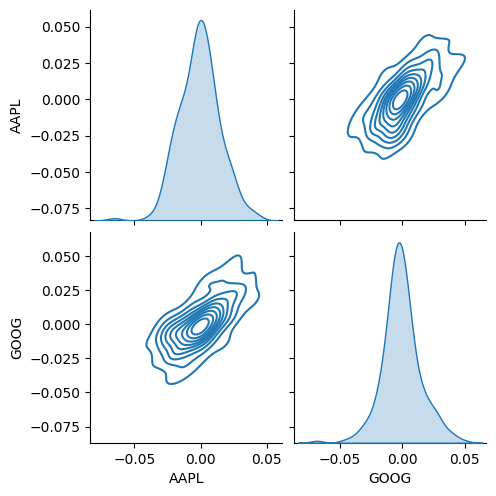

In [ ]:
# pairplot on our DataFrame for an automatic visual analysis of all the comparisons

sns.pairplot(tech_rets, kind='kde')
# with kernel density estimation

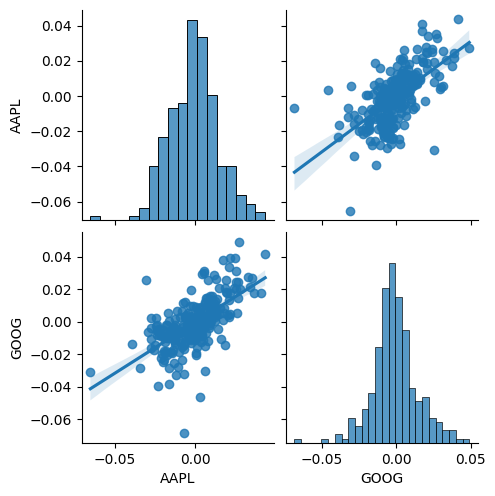

In [ ]:
sns.pairplot(tech_rets, kind='reg')
# We can simply call pairplot on our DataFrame for an automatic visual analysis
# of all the comparisons

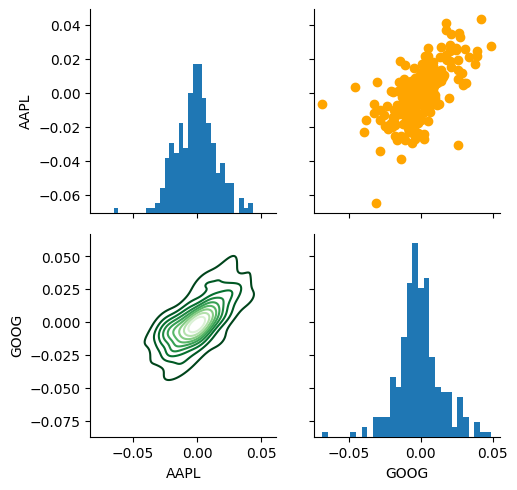

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
return_fig = sns.PairGrid(tech_rets.dropna())

# Using map_upper we can specify what the upper triangle will look like.
return_fig.map_upper(plt.scatter, color='orange')

# We can also define the lower triangle in the figure, inclufing the plot type (kde)
# or the color map (BluePurple)
return_fig.map_lower(sns.kdeplot, cmap='Greens_r')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
return_fig.map_diag(plt.hist, bins=30)

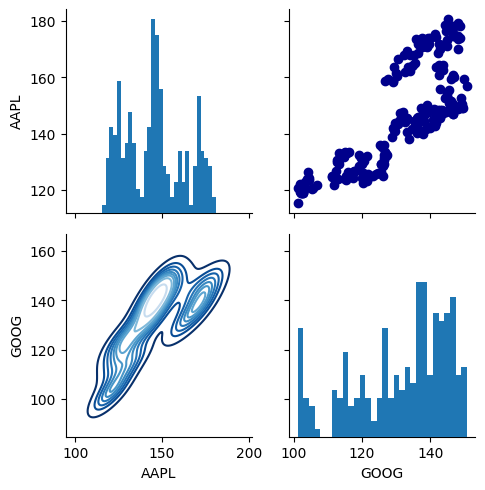

In [ ]:
# Set up our figure by naming it returns_fig, call PairPLot on the DataFrame
returns_fig = sns.PairGrid(closing_df)

# Using map_upper we can specify what the upper triangle will look like.
returns_fig.map_upper(plt.scatter,color='darkblue')

# We can also define the lower triangle in the figure, inclufing the plot type (kde) or the color map (BluePurple)
returns_fig.map_lower(sns.kdeplot,cmap='Blues_r')

# Finally we'll define the diagonal as a series of histogram plots of the daily return
returns_fig.map_diag(plt.hist,bins=30)


**Correlation**

<Axes: xlabel='Symbols', ylabel='Symbols'>

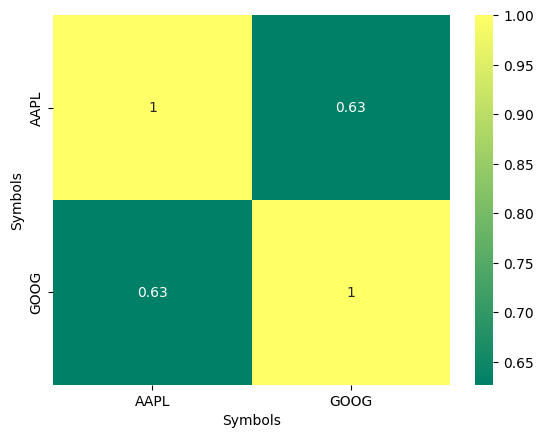

In [ ]:
# correlation plots for  the daily returns
sns.heatmap(tech_rets.corr(), annot=True, cmap='summer')

<Axes: xlabel='Symbols', ylabel='Symbols'>

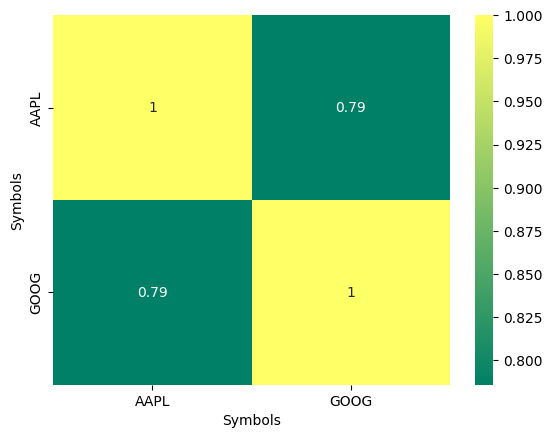

In [ ]:
sns.heatmap(closing_df.corr(), annot=True, cmap='summer')

 We can see the their is a strong correlation between the Google and Apple

## **Risk Analysis**

One of the most basic ways to measure risk is to compare the expected return with the standard deviation of daily returns.

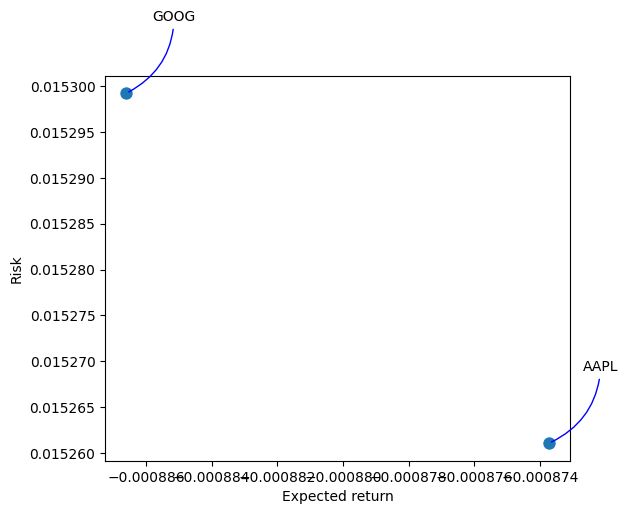

In [ ]:
# Let's start by defining a new DataFrame as a clenaed version of the oriignal tech_rets DataFrame
rets = tech_rets.dropna()

area = np.pi*20

plt.figure(figsize=(6, 5))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Selecting a company and concentrating on analysis on it


In [ ]:
# Summary Stats
company_list[0].describe()

,Open,High,Low,Close,Volume,MA for 10 days,MA for 20 days,MA for 50 days,Daily Return
count,254.000000,254.000000,254.000000,254.000000,2.540000e+02,245.000000,235.000000,205.000000,253.000000
mean,145.564957,147.132280,144.148185,145.713953,8.951935e+07,145.832709,145.880914,145.708637,-0.000874
std,17.368972,17.696412,17.065287,17.396284,2.781299e+07,16.983699,16.358834,14.280972,0.015261
min,117.801000,119.156000,114.999000,115.149000,4.123790e+07,119.919200,120.137550,125.542040,-0.065170
25%,130.477500,131.788500,129.373250,130.646000,6.958339e+07,130.754000,130.267125,132.055160,-0.011657
50%,145.222000,146.588000,144.534000,145.497000,8.520164e+07,145.314000,145.300350,146.246880,-0.000755
75%,158.598750,161.317500,156.697500,159.346500,1.050596e+08,159.414700,155.861475,154.182700,0.008213
max,181.576000,181.885000,178.087000,180.958000,1.970605e+08,177.303100,175.378050,171.707060,0.043465


In [ ]:
company_list[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2022-03-01 to 2021-03-01
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            254 non-null    float64
 1   High            254 non-null    float64
 2   Low             254 non-null    float64
 3   Close           254 non-null    float64
 4   Volume          254 non-null    float64
 5   company_name    254 non-null    object 
 6   MA for 10 days  245 non-null    float64
 7   MA for 20 days  235 non-null    float64
 8   MA for 50 days  205 non-null    float64
 9   Daily Return    253 non-null    float64
dtypes: float64(9), object(1)
memory usage: 21.8+ KB


In [ ]:
Column_List = ["High", "Low", "Open", "Close", "Volume"]

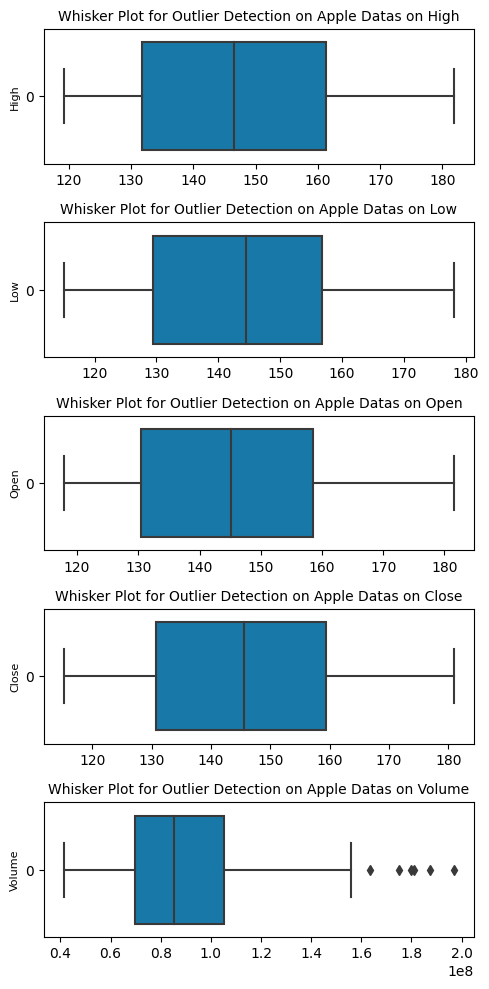

In [ ]:
# Generate whisker plots to detect the presence of any outliers
fig, ax = plt.subplots (len(Column_List), figsize = (5, 10))

for i, col_list in enumerate(Column_List):
    sns.boxplot(company_list[0][col_list], ax = ax[i], palette = "winter", orient = 'h')
    ax[i].set_title("Whisker Plot for Outlier Detection on Apple Datas on" + " " + col_list, fontsize = 10)
    ax[i].set_ylabel(col_list, fontsize = 8)
    fig.tight_layout(pad = 1.1)

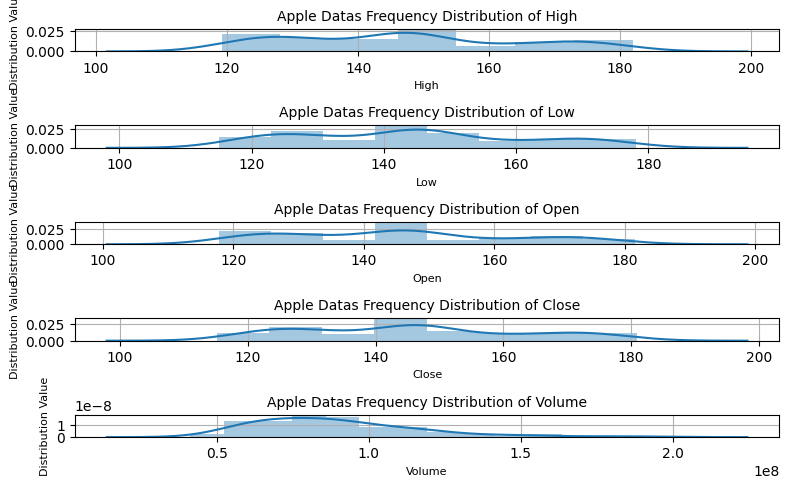

In [ ]:
# Visualize the spread and skweness through the distribution plot

# Use the Column_List : list initialized above in the following steps
fig, ax = plt.subplots(len(Column_List), figsize = (8, 5))

for i, col_list in enumerate(Column_List):
    sns.distplot(company_list[0][col_list], hist = True, ax = ax[i])
    ax[i].set_title ("Apple Datas Frequency Distribution of" + " " + col_list, fontsize = 10)
    ax[i].set_xlabel (col_list, fontsize = 8)
    ax[i].set_ylabel ('Distribution Value', fontsize = 8)
    fig.tight_layout (pad = 1.1) # To provide space between plots
    ax[i].grid('on') # Enabled to view and make markings

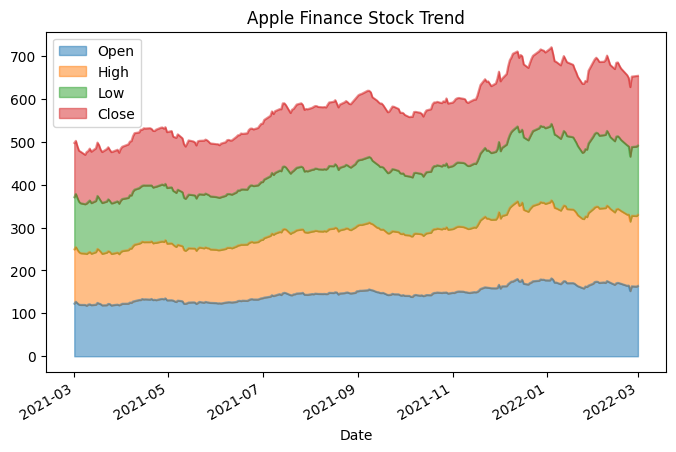

In [ ]:
company_list[0][["Open","High","Low","Close"]].plot.area(figsize=(8,5),alpha=0.5);
plt.title('Apple Finance Stock Trend')
plt.show()

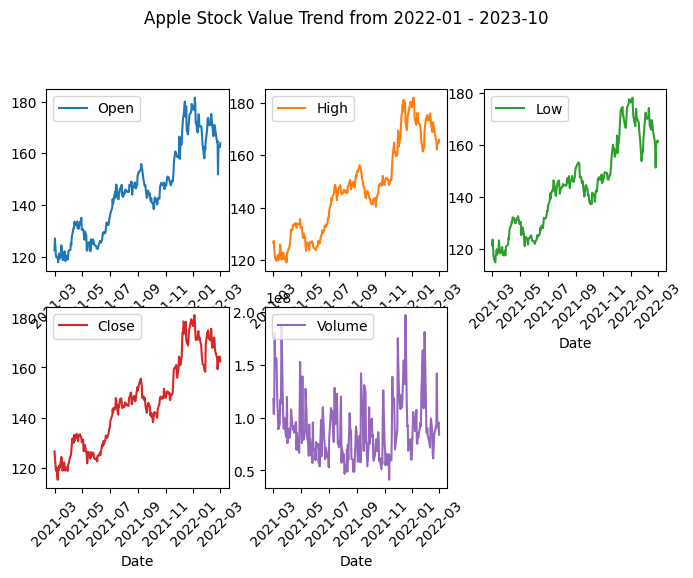

In [ ]:
# A glimpse of how the market shares varied over the given time

# Create a list for numerical columns that are to be visualized
Column_List = ['Open', 'High', 'Low', 'Close', 'Volume']

# Plot to view the same
company_list[0].plot(y = Column_List, subplots = True, layout = (3, 3), figsize = (8, 8), sharex = False, title = "Apple Stock Value Trend from 2022-01 - 2023-10", rot = 45);

# Textual data:

## Accessing dataset from google drive:

In [ ]:
# Mounting drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Get dataset from google drive
df = pd.read_csv('/content/drive/My Drive/india-news-headlines.csv', parse_dates=[0], infer_datetime_format=True,
                 error_bad_lines=False,usecols =["publish_date", "headline_text"])

In [ ]:
# Renaming columns for easy use
df = df.rename(columns = {"publish_date": "Date", "headline_text": "News"})
df.head()

,Date,News
0,2001-01-02,Status quo will not be disturbed at Ayodhya; s...
1,2001-01-02,Fissures in Hurriyat over Pak visit
2,2001-01-02,America's unwanted heading for India?
3,2001-01-02,For bigwigs; it is destination Goa
4,2001-01-02,Extra buses to clear tourist traffic


In [ ]:
df.tail()

,Date,News
3650965,2022-03-31,J&K sacks 2 cops; 3 other employees over terro...
3650966,2022-03-31,Ranbir Kapoor says 'Rishi Kapoor enjoyed his a...
3650967,2022-03-31,As Covid-19 cases drop to nil in southern dist...
3650968,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...
3650969,2022-03-31,Tamil Nadu sees marginal rise of Covid cases w...


## Preprocessing the dataframe:

### Extracting news in the given timeframe:

In [ ]:
start_date = pd.to_datetime('2021-03-01')
end_date = pd.to_datetime('2022-03-01')
df = df.loc[(df['Date'] > start_date) & (df['Date'] < end_date)]

In [ ]:
# Resetting index to start count from 0
df = df.reset_index()

# Remove redudant index columns genrated due to resetting the index
df = df.drop("index", axis=1)

In [ ]:
df.head()

,Date,News
0,2021-03-02,Sudeep to Puneeth: 'Many more years to come an...
1,2021-03-02,Exclusive Interview: Yami Gautam opens up abou...
2,2021-03-02,Sunflower seeds: Nutrition; health benefits an...
3,2021-03-02,Central govt team member visits Yavatmal to as...
4,2021-03-02,Vax drive for senior citizens starts at 13 cen...


### Groupby data by merging news from same date:

In [ ]:
df['News'] = df.groupby(['Date']).transform(lambda x : ' '.join(x)) # Coupling sentences from same date into a long sentence on the same date
df = df.drop_duplicates()
df.reset_index(inplace = True, drop = True)

In [ ]:
df.head()

,Date,News
0,2021-03-02,Sudeep to Puneeth: 'Many more years to come an...
1,2021-03-03,Times 40 Under 40: Celebrating the game change...
2,2021-03-04,Diplomats term vaccine diplomacy a success; ey...
3,2021-03-05,Irfan Pathan's experience of shooting in Russi...
4,2021-03-06,City celebs get vocal about gender equality 6-...


## Text preprocessing:

In [ ]:
df1 = deepcopy(df)

### Convert into lowercase:

In [ ]:
# We need to first split each sentence, so that lower() function doesn't work on each character, but on each word
df1['News'] = df1['News'].apply(lambda x: " ".join(x.lower() for x in x.split()))

### Remove punctuation:

In [ ]:
# Using regex to find and remove any punctuation from the text
df1['News'] = df1['News'].str.replace('[^\w\s]', '')

### Remove stopwords:
Stopwords are defined as the most frequently occuring words in sentences like "and", "or", "is", etc. They are redundant and may hamper our downstream text analysis if not dealt with properly.

In [ ]:
eng_stopwords = stopwords.words('english')
df1['News'] = df1['News'].apply(lambda x: " ".join(x for x in x.split() if x not in eng_stopwords)) # Simply select words not in stopword list

### Deleting words with less than an user-defined count_limit from the text:

In [ ]:
MIN_COUNT_LIMIT = 5
unimp_words = pd.Series(' '.join(df1['News']).split()).value_counts() # get value counts for each words
unimp_words = unimp_words[unimp_words>=MIN_COUNT_LIMIT] # select only words that have >=MIN_COUNT_LIMIT value counts
df1['News'] = df1['News'].apply(lambda x: " ".join(x for x in x.split() if x not in unimp_words))

### Lemmatizing the words:
Since, we stemming could pose a problem for APPLE and GOOGLE company name (turns into APP and GOOG), so we use lemmatization.

In [ ]:
df1['News'] = df1['News'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) # NLTK's wordnet lemmaztizer

In [ ]:
df1.head()

,Date,News
0,2021-03-02,wishing sunflower bikecar moth hupari maple br...
1,2021-03-03,changer brilliant oppos sweating prabhudheva d...
2,2021-03-04,581 bewary hisfate namitha nadirshah jwala cui...
3,2021-03-05,irfan pathan vikrams paappan kannamma roshni b...
4,2021-03-06,sachdeva overlooked someone hrishikesh 1982 sa...


In [ ]:
df1.tail()

,Date,News
359,2022-02-24,anees bazmee horrorcomedy scifi showcasing dho...
360,2022-02-25,revolves prerana involves pranav misshra khati...
361,2022-02-26,lataji shamir kabuliwala retold auntie roomie ...
362,2022-02-27,bankakosi dushyanths sunis sabrina natarajan r...
363,2022-02-28,thimmesh crooned elena welter silliest mojo sh...


## Feature engineering using sentiment analysis:

### Subjectivity and Polarity score:

In [ ]:
df2 = deepcopy(df1)

In [ ]:
df2['Subjectivity'] = df2['News'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df2['Polarity'] = df2['News'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [ ]:
df2.head()

,Date,News,Subjectivity,Polarity
0,2021-03-02,wishing sunflower bikecar moth hupari maple br...,0.600000,0.300
1,2021-03-03,changer brilliant oppos sweating prabhudheva d...,0.825000,-0.200
2,2021-03-04,581 bewary hisfate namitha nadirshah jwala cui...,0.400000,0.025
3,2021-03-05,irfan pathan vikrams paappan kannamma roshni b...,0.975000,-0.050
4,2021-03-06,sachdeva overlooked someone hrishikesh 1982 sa...,0.633333,-0.400


### Sentiment score:

In [ ]:
senti_analyzer = SentimentIntensityAnalyzer()
df2['Compound_score'] = [senti_analyzer.polarity_scores(v)['compound'] for v in df2['News']]
df2['Negative_score'] = [senti_analyzer.polarity_scores(v)['neg'] for v in df2['News']]
df2['Neutral_score'] = [senti_analyzer.polarity_scores(v)['neu'] for v in df2['News']]
df2['Positive_score'] = [senti_analyzer.polarity_scores(v)['pos'] for v in df2['News']]

# Combining textual and numerical features:

## Preparing the final dataset:

In [ ]:
df_merged = pd.merge(num_df, df2, how ='inner', on='Date')
df_merged.head()

,Date,Open,High,Low,Close,Volume,company_name,News,Subjectivity,Polarity,Compound_score,Negative_score,Neutral_score,Positive_score
0,2022-02-28,162.325,164.678,161.697,164.378,9.548666e+07,APPLE,thimmesh crooned elena welter silliest mojo sh...,0.70,0.40,0.1779,0.032,0.918,0.050
1,2022-02-28,133.284,135.640,132.825,134.891,2.967568e+07,GOOGLE,thimmesh crooned elena welter silliest mojo sh...,0.70,0.40,0.1779,0.032,0.918,0.050
2,2022-02-25,163.102,164.378,160.151,164.110,9.239031e+07,APPLE,revolves prerana involves pranav misshra khati...,0.85,0.55,0.4404,0.026,0.933,0.041
3,2022-02-25,133.526,135.389,131.765,134.520,2.623586e+07,GOOGLE,revolves prerana involves pranav misshra khati...,0.85,0.55,0.4404,0.026,0.933,0.041
4,2022-02-24,151.897,162.115,151.318,162.006,1.417861e+08,APPLE,anees bazmee horrorcomedy scifi showcasing dho...,0.00,0.00,-0.8957,0.050,0.950,0.000


In [ ]:
df_merged.tail()

,Date,Open,High,Low,Close,Volume,company_name,News,Subjectivity,Polarity,Compound_score,Negative_score,Neutral_score,Positive_score
499,2021-03-04,101.168,104.462,101.014,102.455,4.236012e+07,GOOGLE,581 bewary hisfate namitha nadirshah jwala cui...,0.400,0.025,0.8176,0.006,0.949,0.045
500,2021-03-03,123.513,124.411,120.572,120.792,1.141518e+08,APPLE,changer brilliant oppos sweating prabhudheva d...,0.825,-0.200,-0.8442,0.065,0.911,0.024
501,2021-03-03,103.360,104.426,100.500,101.336,2.968362e+07,GOOGLE,changer brilliant oppos sweating prabhudheva d...,0.825,-0.200,-0.8442,0.065,0.911,0.024
502,2021-03-02,127.072,127.382,123.713,123.823,1.033341e+08,APPLE,wishing sunflower bikecar moth hupari maple br...,0.600,0.300,-0.5423,0.042,0.929,0.029
503,2021-03-02,103.810,105.218,103.563,103.792,2.269190e+07,GOOGLE,wishing sunflower bikecar moth hupari maple br...,0.600,0.300,-0.5423,0.042,0.929,0.029


In [ ]:
df_final = df_merged[['Close','Subjectivity', 'Polarity', 'Compound_score', 'Negative_score', 'Neutral_score' ,'Positive_score']]
df_final

,Close,Subjectivity,Polarity,Compound_score,Negative_score,Neutral_score,Positive_score
0,164.378,0.700,0.400,0.1779,0.032,0.918,0.050
1,134.891,0.700,0.400,0.1779,0.032,0.918,0.050
2,164.110,0.850,0.550,0.4404,0.026,0.933,0.041
3,134.520,0.850,0.550,0.4404,0.026,0.933,0.041
4,162.006,0.000,0.000,-0.8957,0.050,0.950,0.000
...,...,...,...,...,...,...,...
499,102.455,0.400,0.025,0.8176,0.006,0.949,0.045
500,120.792,0.825,-0.200,-0.8442,0.065,0.911,0.024
501,101.336,0.825,-0.200,-0.8442,0.065,0.911,0.024
502,123.823,0.600,0.300,-0.5423,0.042,0.929,0.029


## Scaling numerical values:

In [ ]:
scaler = MinMaxScaler()
df_final_scaled = pd.DataFrame(scaler.fit_transform(df_final))
df_final_scaled.columns = df_final.columns
df_final_scaled.index = df_final.index
df_final_scaled.head()

,Close,Subjectivity,Polarity,Compound_score,Negative_score,Neutral_score,Positive_score
0,0.792100,0.70,0.700,0.597264,0.246154,0.603865,0.543478
1,0.422357,0.70,0.700,0.597264,0.246154,0.603865,0.543478
2,0.788740,0.85,0.775,0.734311,0.200000,0.676329,0.445652
3,0.417705,0.85,0.775,0.734311,0.200000,0.676329,0.445652
4,0.762357,0.00,0.500,0.036755,0.384615,0.758454,0.000000


## Train-test split:

In [ ]:
X = df_final_scaled.drop("Close", axis=1).values
y = df_final_scaled["Close"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training and evaluation:

## Random forest:

In [ ]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest Model, RMSE:", rmse_rf)

Random Forest Model RMSE:  0.23926470098274807


## Adaboost:

In [ ]:
ada_model = AdaBoostRegressor()
ada_model.fit(X_train, y_train)

AdaBoostRegressor()

In [ ]:
y_pred_ada = ada_model.predict(X_test)
rmse_ada = np.sqrt(mean_squared_error(y_test, y_pred_ada))
print("Random Forest Model, RMSE:", rmse_ada)

Random Forest Model, RMSE: 0.2526442660574665


## XGBoost:

In [ ]:
xgb_model = XGBRegressor(colsample_bytree = 0.6,
                         learning_rate = 0.01,
                         max_depth = 2,
                         n_estimators = 1000)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print("XGB Model, RMSE:", rmse_xgb)

XGB Model, RMSE: 0.2413237285984225


## LightGBM:

In [ ]:
lgbm_model = LGBMRegressor(learning_rate = 0.1,
                           max_depth = 8,
                           n_estimators = 50,
                           colsample_bytree = 0.4,
                           num_leaves = 10)
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Number of data points in the train set: 403, number of used features: 6
[LightGBM] [Info] Start training from score 0.473284


LGBMRegressor(colsample_bytree=0.4, max_depth=8, n_estimators=50, num_leaves=10)

In [ ]:
y_pred_lgbm = xgb_model.predict(X_test)
rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))
print("XGB Model, RMSE:", rmse_lgbm)

XGB Model, RMSE: 0.2413237285984225


## CatBoost:

In [ ]:
cat_model = CatBoostRegressor(iterations = 500,
                         learning_rate = 0.1,
                        depth = 5)
cat_model.fit(X_train, y_train)

In [ ]:
y_pred_cat = xgb_model.predict(X_test)
rmse_cat = np.sqrt(mean_squared_error(y_test, y_pred_cat))
print("XGB Model, RMSE:", rmse_cat)

XGB Model, RMSE: 0.2413237285984225
